# Project Overview

Convolutional Neural Network (CNN) is a powerful tool commonly applied to image analysis
that is capable to outperform humans on some computer vision tasks.

Here an image classification pipeline for dog breed is presented.

The steps of this notebook are:

1. Clone the github repository with all the data to Google Drive
(an authorization is required).
2. Visualization of the training set.
3. Training of CNN model using transfer learning.
4. Classification of new data.



# Model

Given the large computer and time resources
required to develop neural network models,
**transfer learning** becomes an interesting option
on the area of computer vision.
In transfer learning,
a pre-trained model is used as starting point
for a second target network.

Here the InceptionV3, Xception, InceptionResNetV2, and VGG-16
[models](https://keras.io/api/applications/)
are used as starting point for image classification.



# Datasets

Three datasets are used in this project.

* ImageNet

  The pretrained VGG-16 model uses the
  [ImageNet](https://image-net.org/)
  database of images.
  This is a large database designed for use in visual object
  recognitiion.

* Images scraped from Google

  Additional data
  for training, validation and testing of the model
  was scrapped using Selenium,
  an open-source web-based automation tool.
  This additional was downloaded from google,
  compressed and stored in a
  [Github repository](https://github.com/oliveirampo/dog_breed_classification).
  New data can also be downloaded using the script provided
  [here](https://github.com/oliveirampo/dog_breed_classification/blob/main/scr/download_image.py).

* Images provided in the [Kaggle competion](https://www.kaggle.com/c/dog-breed-identification/data) for dog breed identification.

  The dataset comprises 10000 images related to 120 breeds of dogs.

# Metrics

The performance of the models trained is computed in terms of the accuracy, which is defined as
the number of corrected predictions divided by the total number of predictions, multiplyed by 100.

The dataset used here for image classification is balanced, thus accuracy is an appropriate option.
Otherwise, other metrics such as precision and recall could be better choices.



# Clone Repository and Import Libraries

Mount google drive - Click on the link and give authorization


In [1]:
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install selenium

In [3]:
import sys
import os

In [4]:
projDir = '/content/drive/MyDrive/github_projects'

if not os.path.exists(projDir):
  os.makedirs(projDir)

%cd $projDir
%ls

/content/drive/MyDrive/github_projects
dog_breed_classification/  extra_data/  miniconda/


In [5]:
!git init .
!git clone https://github.com/oliveirampo/dog_breed_classification.git


Reinitialized existing Git repository in /content/drive/MyDrive/github_projects/.git/
fatal: destination path 'dog_breed_classification' already exists and is not an empty directory.


In [6]:
%cd $projDir/dog_breed_classification/

!git pull https://github.com/oliveirampo/dog_breed_classification.git

print()
%ls

/content/drive/MyDrive/github_projects/dog_breed_classification
remote: Enumerating objects: 6, done.
remote: Counting objects: 100% (6/6), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 6 (delta 3), reused 6 (delta 3), pack-reused 0
Unpacking objects: 100% (6/6), done.
From https://github.com/oliveirampo/dog_breed_classification
 * branch            HEAD       -> FETCH_HEAD
Updating 70adc9c..1f562fe
Fast-forward
 README.md         |  36 ++++--
 train_model.ipynb | 320 +++++++++---------------------------------------------
 2 files changed, 77 insertions(+), 279 deletions(-)

data/       lixo/   README.md         scr/
flask_app/  model/  requirements.txt  train_model.ipynb


Import libraries.

In [7]:
from scr import plot

In [8]:
%matplotlib inline 
import matplotlib.pyplot as plt
from PIL import Image
import pandas as pd
import numpy as np

from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
from tensorflow.keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input as preprocess_input_vgg16

from tensorflow.keras.preprocessing import image

# from keras.callbacks import ModelCheckpoint  

from tensorflow.keras.models import load_model
# from tensorflow.keras.models import Model, Sequential

from keras.callbacks import EarlyStopping
from keras.preprocessing.image import load_img
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.utils import to_categorical

from keras.layers import GlobalAvgPool2D, Dense, Flatten, Dropout
from keras.layers import BatchNormalization, Dense, GlobalAveragePooling2D, Lambda, Dropout, InputLayer, Input

from keras.models import Model
from keras.models import Sequential

from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input as preprocess_input_inception_v3
from keras.applications.xception import Xception
from keras.applications.xception import preprocess_input as preprocess_input_xception
from keras.applications.inception_resnet_v2 import InceptionResNetV2
from keras.applications.inception_resnet_v2 import preprocess_input as preprocess_input_inception_resnet_v2


# Load Data

Unzip images to tmp/directorory

In [9]:
%ls data/dogs/

zip_file = 'data/dogs/train.zip'

train_directory = '/content/sample_data/train'
if not os.path.exists(train_directory):
  !unzip $zip_file -d /content/sample_data/


chow_chow.jpg  labels.csv  train.zip


Get data from [Kaggle competition](https://www.kaggle.com/c/dog-breed-identification/data).

Please download the data (labels.csv and train.zip) to your Drive and update the path below.

In [10]:
use_kaggle_data = False
zip_file_kaggle = '../extra_data/train_kaggle.zip'

train_directory_kaggle = '/content/sample_data/kaggle_train'
if use_kaggle_data:
  if not os.path.exists(train_directory_kaggle):
    os.makedirs(train_directory_kaggle)
    !unzip $zip_file_kaggle -d $train_directory_kaggle

Get categories

In [11]:
df = pd.read_csv('data/dogs/labels.csv')
dog_breeds = sorted(df['breed'].unique())
n_classes = len(dog_breeds)

n_classes

114

Get categories from kaggle

In [12]:
if use_kaggle_data:
  df_kaggle = pd.read_csv('../extra_data/labels_kaggle.csv')

Join categories

In [13]:
if use_kaggle_data:
  df = df.append(df_kaggle)
  del df_kaggle
  
  dog_breeds = sorted(df['breed'].unique())
  n_classes = len(dog_breeds)

  print(n_classes)

In [14]:
# Converting classes to numbers
class_to_num = dict(zip(dog_breeds, range(n_classes)))
num_to_class = dict(zip(range(n_classes), dog_breeds))

# Data Visualization

Load and convert images to array

In [15]:
def images_to_array(data_dir, data_dir_kaggle, df, image_size, class_to_num):
    """Convert image to array.

    :param data_dir: (str) Path of images with png format.
    :param data_dir_kaggle: (str) Secondary path with images in jpg format.
    :param df (pandas dataframe) Table with id and classification of images.
    :param image_size (tuple) Image size (224, 224, 3).
    :param class_to_num (dict) Map ot class to integer.

    :return
      X (arr) Features.
      y (arr) Classes in categorical format.
    """
    
    image_names = df['id'].values
    image_labels = df['breed'].values
    data_size = len(image_names)
    # data_size = 70

    X = np.zeros([data_size, image_size[0], image_size[1], image_size[2]], dtype=np.uint8)
    y = np.zeros([data_size, 1], dtype=np.uint8)

    for i in range(data_size):
        img_name = image_names[i]

        img_dir = '{}/{}.png'.format(data_dir, img_name)

        try:
          img_pixels = load_img(img_dir, target_size=image_size)
          
        except FileNotFoundError:
          img_dir = '{}/{}.jpg'.format(data_dir_kaggle, img_name)
          img_pixels = load_img(img_dir, target_size=image_size)
          

        X[i] = img_pixels
        y[i] = class_to_num[image_labels[i]]

    y = to_categorical(y)

    ind = np.random.permutation(data_size)
    X = X[ind]
    y = y[ind]

    return X, y

In [16]:
img_size = (224, 224, 3)
X, y = images_to_array(train_directory, train_directory_kaggle, df, img_size, class_to_num)
print(X.shape)
print(y.shape)

(6840, 224, 224, 3)
(6840, 114)


In [17]:
num_images = X.shape[0]

print('There are {} categories.'.format(n_classes))
print('There are {} images at total.'.format(X.shape[0]))
# print('There are {} ({:.1f} %) images at total.'.format(X.shape[0], 100.0 * X.shape[0] / num_images))

There are 114 categories.
There are 6840 images at total.


Example of images:

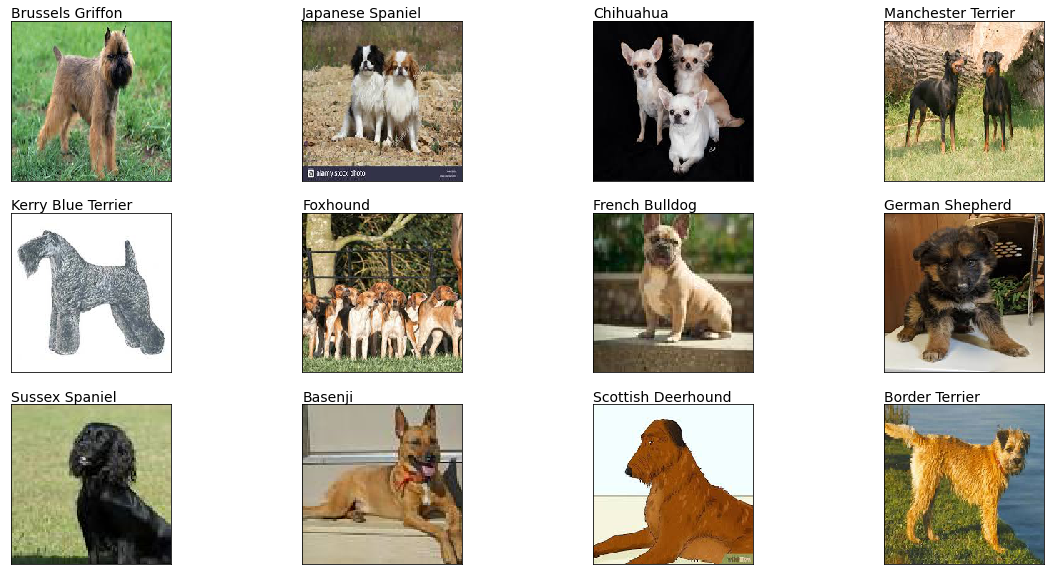

In [18]:
fig = plot.plot_images(3, 4, 12, X, y, num_to_class)

Note that this data has been downloaded from Google
and no cleaning steps were performed.

# Extract Features

In [19]:
n_split_train = int(X.shape[0] * 0.8)

print('Training set containst {} ({:.1f} %) images.'.format(n_split_train, 100.0 * n_split_train / X.shape[0]))
print('Test set containst {} ({:.1f} %) images.'.format(X.shape[0] - n_split_train, 100.0 * (X.shape[0] - n_split_train) / X.shape[0]))

Training set containst 5472 (80.0 %) images.
Test set containst 1368 (20.0 %) images.


In [20]:
def get_features(model_name, data_preprocessor, input_size, data):
    """Prepare pipeline to extract features.

    :param model_name: (keras model)
    :param data_preprocessor: (keras preprocess input object)
    :param input_size (tuple) Image size (224, 224, 3).
    :param data: (arr) Images converted to matrix.

    :return
      feature_maps: (arr) Preprocessed features
    """
    
    input_layer = Input(input_size)
    preprocessor = Lambda(data_preprocessor)(input_layer)
    base_model = model_name(weights='imagenet', include_top=False,
                            input_shape=input_size)(preprocessor)
    avg = GlobalAveragePooling2D()(base_model)
    feature_extractor = Model(inputs=input_layer, outputs=avg)
    # Extract feature.
    feature_maps = feature_extractor.predict(data, batch_size=32, verbose=1)
    print('Feature maps shape: ', feature_maps.shape)
    return feature_maps

In [21]:
def get_combined_features(X, img_size):
  """Combine features from preprocessing steps using:
        - InceptionV3
        - Xception
        - InceptionResnetV2

      :param X: (arr) Images converted to array.
      :param img_size (tuple) Image size (224, 224, 3).

      :return
        final_features: (arr) Combined features.
  """

  # Extracting features using InceptionV3
  inception_preprocessor = preprocess_input_inception_v3
  inception_features = get_features(InceptionV3, inception_preprocessor, img_size, X)
  
  # Extracting features using Xception
  xception_preprocessor = preprocess_input_xception
  xception_features = get_features(Xception, xception_preprocessor, img_size, X)

  # Extracting features using InceptionResnetV2
  inc_resnet_preprocessor = preprocess_input_inception_resnet_v2
  inc_resnet_features = get_features(InceptionResNetV2, inc_resnet_preprocessor,
                                     img_size, X)
  
  # Concatenating features
  final_features = np.concatenate([inception_features,
                                  xception_features,
                                  inc_resnet_features, ], axis=-1)
  
  return final_features


In [22]:
features_train = get_combined_features(X[:n_split_train], img_size)

171/171 [==============================] - 23s 41ms/step
Feature maps shape:  (5472, 2048)
171/171 [==============================] - 15s 71ms/step
Feature maps shape:  (5472, 2048)
171/171 [==============================] - 31s 101ms/step
Feature maps shape:  (5472, 1536)


In [23]:
# del X

# Model Training

In [24]:
#Callbacks
EarlyStop_callback = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
my_callback=[EarlyStop_callback]

In [25]:
#Building Model
model = Sequential()
model.add(InputLayer(features_train.shape[1:]))
model.add(Dropout(0.7))
model.add(Dense(y.shape[1],activation='softmax'))

In [26]:
#Compiling Model
model.compile(optimizer='adam',
            loss='categorical_crossentropy',
            metrics=['accuracy'])

In [27]:
#Training Model
history = model.fit(features_train,
                  y[:n_split_train],
                  batch_size=32,
                  epochs=50,
                  validation_split=0.1,
                  callbacks=my_callback)

Epoch 1/50
154/154 [==============================] - 7s 5ms/step - loss: 3.7596 - accuracy: 0.2998 - val_loss: 1.3457 - val_accuracy: 0.6788
Epoch 2/50
154/154 [==============================] - 0s 3ms/step - loss: 1.2747 - accuracy: 0.6848 - val_loss: 1.4208 - val_accuracy: 0.6770
Epoch 3/50
154/154 [==============================] - 0s 3ms/step - loss: 1.0544 - accuracy: 0.7316 - val_loss: 1.4122 - val_accuracy: 0.7007
Epoch 4/50
154/154 [==============================] - 0s 3ms/step - loss: 0.8694 - accuracy: 0.7670 - val_loss: 1.4553 - val_accuracy: 0.7172
Epoch 5/50
154/154 [==============================] - 0s 3ms/step - loss: 0.7037 - accuracy: 0.7942 - val_loss: 1.5836 - val_accuracy: 0.7172
Epoch 6/50
154/154 [==============================] - 0s 3ms/step - loss: 0.6440 - accuracy: 0.8149 - val_loss: 1.6568 - val_accuracy: 0.7153
Epoch 7/50
154/154 [==============================] - 0s 3ms/step - loss: 0.6092 - accuracy: 0.8255 - val_loss: 1.6685 - val_accuracy: 0.7172
Epoch 

In [28]:
def train_model_2(img_size, X, y):
  """Build and train model using VGG-16.

  :param img_size (tuple) Image size (224, 224, 3).
  :param X: (arr) Features.
  :param y: (arr) Classes.
  """

  vgg16_preprocessor = preprocess_input_vgg16
  vgg16_features = get_features(VGG16, vgg16_preprocessor, img_size, X)
  final_features = np.concatenate([vgg16_features,], axis=-1)
  print('Final feature maps shape', final_features.shape)

  #Callbacks
  EarlyStop_callback = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
  my_callback = [EarlyStop_callback]

  #Building Model2
  model = Sequential()
  model.add(InputLayer(final_features.shape[1:]))
  model.add(Dense(1024, activation='relu'))
  model.add(Dropout(0.7))
  model.add(Dense(y.shape[1],activation='softmax'))

  #Compiling Model
  model.compile(optimizer='adam',
            loss='categorical_crossentropy',
            metrics=['accuracy'])
  
  #Training Model
  history = model.fit(vgg16_features,
                  y,
                  batch_size=32,
                  epochs=100,
                  validation_split=0.1,
                  callbacks=my_callback)
  
  return model, history


In [29]:
model_2, history_2 = train_model_2(img_size, X[:n_split_train], y[:n_split_train])

The following Variables were used a Lambda layer's call (tf.nn.convolution), but
are not present in its tracked objects:
  <tf.Variable 'block1_conv1/kernel:0' shape=(3, 3, 3, 64) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.bias_add), but
are not present in its tracked objects:
  <tf.Variable 'block1_conv1/bias:0' shape=(64,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.convolution_1), but
are not present in its tracked objects:
  <tf.Variable 'block1_conv2/kernel:0' shape=(3, 3, 64, 64) dtype=float32>
It is possible that this is int

## Save best model

In [30]:
model_path = projDir + '/dog_breed_classification/model'
model_path

'/content/drive/MyDrive/github_projects/dog_breed_classification/model'

In [31]:
model.save(model_path)

INFO:tensorflow:Assets written to: /content/drive/MyDrive/github_projects/dog_breed_classification/model/assets


Reconstruct the trained model


In [32]:
model = load_model(model_path)

In [33]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dropout (Dropout)            (None, 5632)              0         
_________________________________________________________________
dense (Dense)                (None, 114)               642162    
Total params: 642,162
Trainable params: 642,162
Non-trainable params: 0
_________________________________________________________________


# Results

## Evolution of Loss Function

In [34]:
def plot_optimization_Results(history):
  """Plot evolution of optimization.
  
  :param history (tensorflow History)
  """

  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']

  loss = history.history['loss']
  val_loss = history.history['val_loss']

  # epochs_range = range(epochs)
  epochs_range = range(len(acc))

  plt.figure(figsize=(8, 8))
  plt.subplot(1, 2, 1)
  plt.plot(epochs_range, acc, label='Training Accuracy')
  plt.plot(epochs_range, val_acc, label='Validation Accuracy')
  plt.legend(loc='lower right')
  plt.title('Training and Validation Accuracy')

  plt.subplot(1, 2, 2)
  plt.plot(epochs_range, loss, label='Training Loss')
  plt.plot(epochs_range, val_loss, label='Validation Loss')
  plt.legend(loc='upper right')
  plt.title('Training and Validation Loss')
  plt.show()

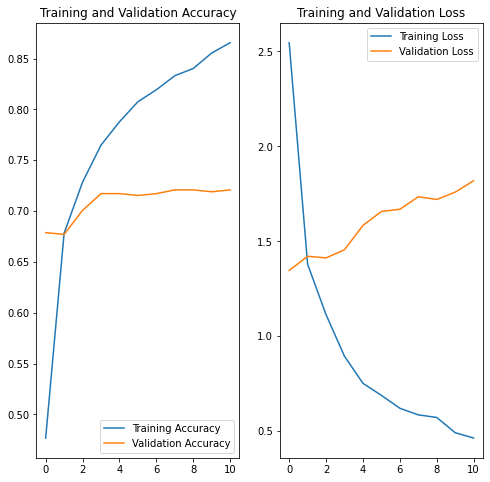

In [35]:
plot_optimization_Results(history)

## Model Accuracy

In [36]:
features_test = get_combined_features(X[n_split_train:], img_size)

43/43 [==============================] - 7s 49ms/step
Feature maps shape:  (1368, 2048)
43/43 [==============================] - 6s 78ms/step
Feature maps shape:  (1368, 2048)
43/43 [==============================] - 18s 107ms/step
Feature maps shape:  (1368, 1536)


In [37]:
def get_accuracy_from_features(model, features, y_test, categories):
  """Compute accuracy of model.

  :param model: (keras model)
  :param features: (arr)
  :param y_text: (arr) Classes in categorical format.
  :param_categories: (dict) Map of integer code to class name.

  :return
    accuracy: (float)
  """

  # predict classes
  y_pred = model.predict(features)
  top_indices = np.array([y_pred[i].argsort()[-1] for i in range(y_pred.shape[0])])
  predicted_classes = np.array([categories[i] for i in top_indices])

  # get actual classes
  _, cols = np.where(y_test == 1)
  actual_classes = np.array([categories[i] for i in cols])

  # compare predicted and actual values
  results_bool = (predicted_classes == actual_classes)

  # compute accuracy
  accuracy = np.sum(results_bool) / results_bool.shape[0]

  return accuracy

In [38]:
accuracy = get_accuracy_from_features(model, features_test, y[n_split_train:], num_to_class)
print('The accuracy in the test set is {:.2f}'.format(accuracy))

The accuracy in the test set is 0.67


## Testing on Additional Images

In [39]:
test_image_path = "data/dogs/chow_chow.jpg"
# test_image_path = projDir + '../data'
%ls $test_image_path

data/dogs/chow_chow.jpg


In [40]:
def classify_image(img_path, img_size, model, categories, top=3):
    """Example from Keras of how to classify single image with given model."""

    img = image.load_img(img_path, target_size=img_size[:2])

    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)

    features = get_combined_features(x, img_size)

    y_pred = model.predict(features)[0]
    
    top_indices = y_pred.argsort()[-top:][::-1]
    results = [{"breed": categories[i], "percentage": '{:.2f}'.format(y_pred[i] * 100.0)} for i in top_indices]
    return results

In [41]:
results = classify_image(test_image_path, img_size, model, num_to_class)
results

1/1 [==============================] - 6s 6s/step
Feature maps shape:  (1, 2048)
1/1 [==============================] - 3s 3s/step
Feature maps shape:  (1, 2048)
1/1 [==============================] - 14s 14s/step
Feature maps shape:  (1, 1536)


[{'breed': 'chow_chow', 'percentage': '45.62'},
 {'breed': 'samoyed', 'percentage': '42.12'},
 {'breed': 'spitz', 'percentage': '6.87'}]

# Final considerations

The accuracy of the model using VGG-16 is not as high
as the one combining three pretrained models
(InceptionV3, Xception, InceptionResNetV2).

For the later the accuracy obtained is equal to 67 %.
If the training set is increased by 10000 images
(*e.g.* using
[Kaggle](https://www.kaggle.com/c/dog-breed-identification/data)
images), the accuracy increases to 70 %.

Further improved could be possibly obtained by:
  - Increasing the number of layers;
  - Changing the droupout regularization constant;
  - Trying different architectures;
